In [1]:
# Read json file
import json
import numpy as np
import requests
import os
import pandas as pd
from sklearn import preprocessing
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

# Dataframe

In [50]:
playlists_df = pd.read_csv('playlists_embeddings_small.csv')

# Train test split
np.random.seed(42)
msk = np.random.rand(len(playlists_df)) < 0.8
playlists_df, test_playlists_df = playlists_df[msk], playlists_df[~msk]

headers = playlists_df.columns.values.tolist()

print(headers)

['index', 'title', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']


In [51]:
mean = playlists_df[headers[2:]].mean(axis=0)
std = playlists_df[headers[2:]].std(axis=0)

playlists_df[headers[2:]] = (playlists_df[headers[2:]] - mean) / std
test_playlists_df[headers[2:]] = (test_playlists_df[headers[2:]] - mean) / std

In [52]:
playlists = json.load(open('playlists.json', 'r'))
tracks = json.load(open('track_features.json', 'r'))

# Clustering

### K-means

In [70]:
# K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def get_cluster_tracks(playlists_df, cluster_preds, num_clusters, verbose=False):
    global playlists, tracks
    
    playlists_clustered = playlists_df.get(['index', 'title']).copy()
    playlists_clustered['cluster'] = cluster_preds

    cluster_tracks = [{} for _ in range(num_clusters)]
    for cluster in range(num_clusters):
        for i in playlists_clustered[playlists_clustered['cluster'] == cluster]['index']:
            for track in playlists[i][1]:
                if track['track_uri'] not in cluster_tracks[cluster]:
                    cluster_tracks[cluster][track['track_uri']] = track
        cluster_tracks[cluster] = np.array(list(cluster_tracks[cluster].values()))

        if verbose:
            print('Cluster {}: {} tracks'.format(cluster, len(cluster_tracks[cluster])))

    return cluster_tracks

def track_disc_score(playlists_df, cluster_preds, num_clusters):
    global tracks
    
    cluster_tracks = get_cluster_tracks(playlists_df, cluster_preds, num_clusters)

    lengths = np.array([len(tracks) for tracks in cluster_tracks])
    return  np.sum(lengths) / len(tracks), np.max(lengths)/np.mean(lengths)

In [54]:
for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto').fit(playlists_df[headers[2:]])
    labels = kmeans.labels_

    print("n_clusters = {}, track_disc = {}, davies_bouldin = {}".format(
        i, track_disc_score(playlists_df, labels, i),
        davies_bouldin_score(playlists_df[headers[2:]], labels)))

n_clusters = 2, track_disc = (1.0072019995024935, 1.257065236566348), davies_bouldin = 2.4422086971906394
n_clusters = 3, track_disc = (1.1058297106170265, 1.2095409738606022), davies_bouldin = 3.2330239855985545
n_clusters = 4, track_disc = (1.1837368664194927, 1.4658431087061483), davies_bouldin = 3.0480227020348156
n_clusters = 5, track_disc = (1.2583835775458714, 1.6474010203889526), davies_bouldin = 2.820898887341798
n_clusters = 6, track_disc = (1.1937373402352496, 2.6147316090556827), davies_bouldin = 2.1219352941680993
n_clusters = 7, track_disc = (1.207495765271674, 2.8918484765249466), davies_bouldin = 2.1717501068998066
n_clusters = 8, track_disc = (1.3600999751246727, 1.9166180402539605), davies_bouldin = 2.5138973788664405
n_clusters = 9, track_disc = (1.333643287807536, 2.8828777617408683), davies_bouldin = 2.305803685959574
n_clusters = 10, track_disc = (1.385869629594532, 3.042954276409978), davies_bouldin = 2.1936028850455758
n_clusters = 11, track_disc = (1.4436218476

In [64]:
NUM_CLUSTERS = 15
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto').fit(playlists_df[headers[2:]])

In [65]:
# Group playlists by cluster
playlists_df['cluster'] = kmeans.labels_
playlists_clustered = playlists_df.get(['index', 'title', 'cluster'])

In [66]:
# Count most common titles
def count_words(titles):
    words = []
    for title in titles:
        title = str(title).strip().lower()
        words += title.split(" ")
    return Counter(words)


for i in range(NUM_CLUSTERS):
    print(count_words(
        playlists_clustered[playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('jams', 343), ('jamz', 65), ('jam', 60), ('slow', 35), ('my', 25), ('summer', 23), ('car', 23), ('old', 22), ('jammin', 16), ('school', 11)]
[('the', 78), ('road', 72), ('mix', 69), ('party', 69), ('wedding', 68), ('car', 54), ('spanish', 50), ('shower', 49), ('trip', 44), ('beach', 38)]
[('music', 401), ('playlist', 347), ('songs', 329), ('good', 84), ('my', 80), ('tunes', 73), ('party', 40), ('the', 32), ('favorite', 31), ('new', 29)]
[('workout', 318), ('gym', 96), ('running', 85), ('work', 45), ('out', 43), ('run', 23), ('my', 14), ('mix', 14), ('cardio', 12), ('playlist', 12)]
[('rock', 300), ('edm', 80), ('pop', 52), ('indie', 44), ('new', 44), ('punk', 43), ('metal', 42), ('alternative', 37), ('mix', 30), ('alt', 28)]
[('christmas', 256), ('disney', 107), ('songs', 78), ('the', 77), ('music', 53), ('sleep', 51), ('love', 48), ('wedding', 47), ('sad', 38), ('mellow', 35)]
[('country', 859), ('summer', 22), ('new', 22), ('old', 16), ('classic', 15), ('music', 15), ('texas', 14),

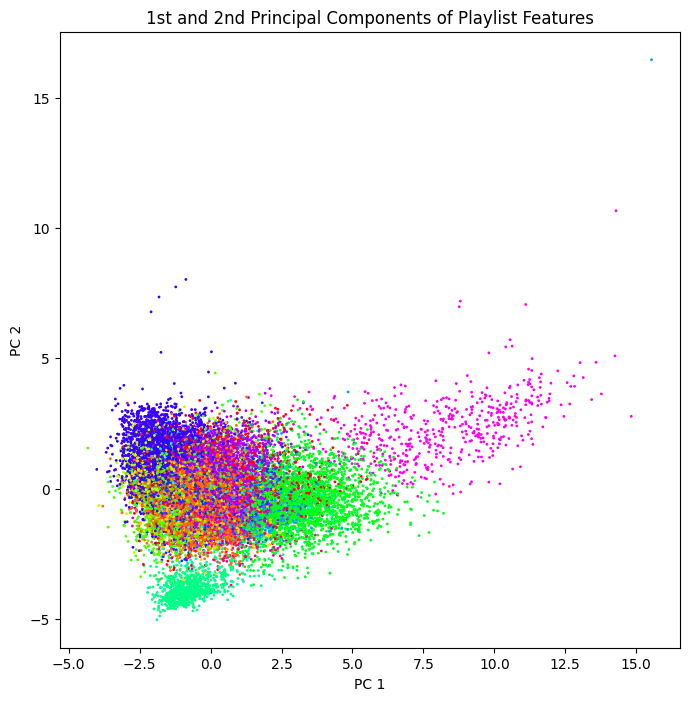

In [67]:
pca = PCA()
pca.fit(playlists_df[headers[2:]])
x = pca.transform(playlists_df[headers[2:]])[:, 0]
y = pca.transform(playlists_df[headers[2:]])[:, 1]

# Plot clusters
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=kmeans.labels_, s=1, cmap='hsv')
plt.title("1st and 2nd Principal Components of Playlist Features")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [72]:
get_cluster_tracks(playlists_df, kmeans.labels_, NUM_CLUSTERS, verbose=True)


Cluster 0: 20382 tracks
Cluster 1: 86590 tracks
Cluster 2: 40001 tracks
Cluster 3: 17945 tracks
Cluster 4: 62435 tracks
Cluster 5: 63390 tracks
Cluster 6: 11336 tracks
Cluster 7: 14203 tracks
Cluster 8: 14863 tracks
Cluster 9: 39451 tracks
Cluster 10: 48173 tracks
Cluster 11: 66650 tracks
Cluster 12: 21858 tracks
Cluster 13: 19876 tracks
Cluster 14: 28091 tracks


[array([{'pos': 0, 'artist_name': 'Calle 13', 'track_uri': 'spotify:track:1q8NdCAQ9QUjpYiqzdd3mv', 'artist_uri': 'spotify:artist:0yNSzH5nZmHzeE2xn6Xshb', 'track_name': 'Atrévete-Te-Te', 'album_uri': 'spotify:album:5pmuwmV2OcuiTX7kNczQ16', 'duration_ms': 239307, 'album_name': 'Calle 13 (Explicit Version)', 'danceability': 0.829, 'energy': 0.878, 'key': 9, 'loudness': -5.951, 'mode': 1, 'speechiness': 0.101, 'acousticness': 0.0959, 'instrumentalness': 0, 'liveness': 0.776, 'valence': 0.883, 'tempo': 87.991, 'time_signature': 4},
        {'pos': 1, 'artist_name': 'Xtreme', 'track_uri': 'spotify:track:0muI8DpTEpLqqibPm3sKYf', 'artist_uri': 'spotify:artist:47bVt95bvBMpmJFWoyhH0C', 'track_name': 'Te Extraño - Bachata Version', 'album_uri': 'spotify:album:66g9Nydw29UNG9b2ndrlRi', 'duration_ms': 212973, 'album_name': 'Xtreme', 'danceability': 0.792, 'energy': 0.605, 'key': 6, 'loudness': -4.407, 'mode': 0, 'speechiness': 0.0341, 'acousticness': 0.786, 'instrumentalness': 0, 'liveness': 0.0877,

### DBSCAN

In [ ]:
# DBSCAN
from sklearn.cluster import DBSCAN


for e in range(14, 20):
    e /= 10
    for min_samples in range(2, 10):
        db = DBSCAN(eps=e, min_samples=min_samples).fit(playlists_df[headers[2:]])
        labels = db.labels_ + 1 # now 0 is noise

        clusters = len(set(labels))
        noisy = len([l for l in labels if l == 0])

        print("eps = {}, min_samples = {}, clusters = {}, noisy = {}".format(
            e, min_samples, clusters, noisy), end="")

        if clusters > 1 and noisy < len(playlists_df) / clusters:
            print(", track_disc = {}, davies_bouldin = {}".format(
                track_disc_score(playlists_df, labels, len(set(labels))),
                davies_bouldin_score(playlists_df[headers[2:]], labels)))
        else:
            print()

In [40]:
eps = 1.6
min_samples = 9

db = DBSCAN(eps=eps, min_samples=min_samples).fit(playlists_df[headers[2:]])
labels = db.labels_ + 1 # now 0 is noise

In [41]:
playlists_clustered = playlists_df.get(['index', 'title']).copy()
playlists_clustered['cluster'] = labels

clusters = len(set(labels))
cluster_tracks = [set() for _ in range(clusters)]
for cluster in range(clusters):
    for i in playlists_clustered[playlists_clustered['cluster'] == cluster]['index']:
        for track in playlists[i][1]:
            cluster_tracks[cluster].add(track['track_uri'])

lengths = np.array([len(tracks) for tracks in cluster_tracks])
lengths

array([ 86547, 241716,    679,    525])

In [42]:
for i in range(clusters):
    print(count_words(
        playlists_clustered[playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('music', 96), ('chill', 84), ('songs', 64), ('classical', 59), ('the', 55), ('christmas', 51), ('jazz', 48), ('new', 44), ('sleep', 42), ('good', 42)]
[('country', 864), ('chill', 584), ('music', 508), ('summer', 474), ('songs', 408), ('rock', 395), ('good', 369), ('party', 364), ('playlist', 343), ('jams', 336)]
[('harry', 2), ('potter', 2), ('soundtracks', 2), ('soundtrack', 1), ('speechless', 1), ('movie', 1), ('music', 1), ('study', 1), ('calm', 1)]
[('disney', 5), ('various', 2), ('artists', 2), ('–', 2), ('frozen', 2), ('oldie', 1), ('music', 1), ('<3', 1), ('movies', 1)]


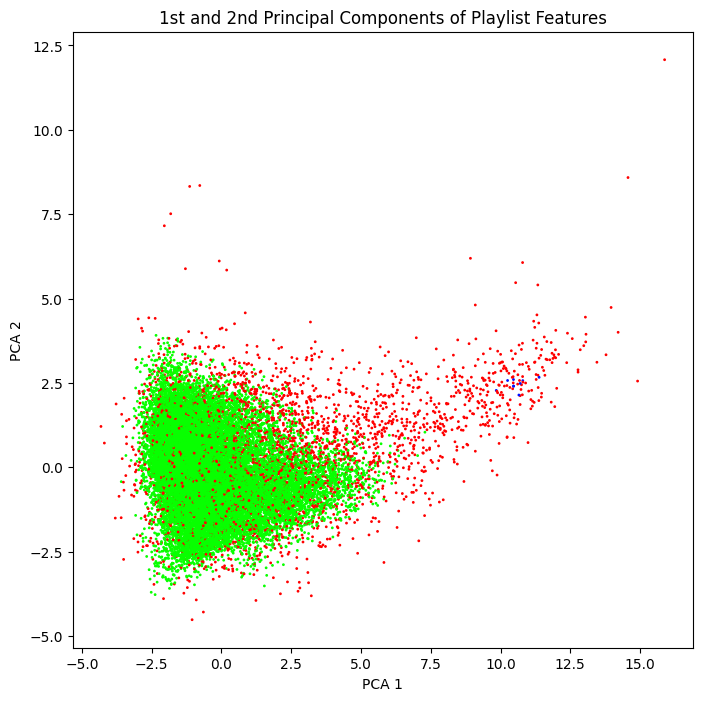

In [43]:
pca = PCA()
pca.fit(playlists_df[headers[2:]])
x = pca.transform(playlists_df[headers[2:]])[:, 0]
y = pca.transform(playlists_df[headers[2:]])[:, 1]

# Plot clusters
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=labels, s=1, cmap='hsv')
plt.title("1st and 2nd Principal Components of Playlist Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Test data

In [15]:
test_playlists_df['cluster'] = kmeans.predict(test_playlists_df[headers[2:]])
test_playlists_clustered = test_playlists_df.get(['index', 'title', 'cluster'])

for i in range(NUM_CLUSTERS):
    print(count_words(
        test_playlists_clustered[test_playlists_clustered['cluster'] == i]['title'].values.tolist()).most_common(10))

[('workout', 92), ('gym', 25), ('run', 21), ('out', 18), ('work', 17), ('running', 15), ('up', 9), ('mix', 6), ('my', 6), ('high-intensity', 6)]
[('summer', 112), ('2016', 71), ('2017', 67), ('2015', 39), ('spring', 25), ('fall', 23), ('2014', 20), ('17', 19), ('april', 15), ('july', 15)]
[('party', 79), ('dance', 36), ('lit', 32), ('edm', 29), ('mix', 29), ('road', 26), ('throwback', 26), ('trip', 23), ('random', 23), ('throwbacks', 22)]
[('rap', 81), ('rock', 74), ('jams', 65), ('jamz', 22), ('hip', 21), ('hop', 21), ('beats', 14), ('reggae', 14), ('slow', 12), ('my', 12)]
[('study', 15), ('music', 13), ('classical', 11), ('sleep', 7), ('instrumental', 6), ('jazz', 5), ('piano', 5), ('movie', 4), ('soundtracks', 4), ('time', 4)]
[('good', 64), ('vibes', 42), ('new', 40), ('feels', 27), ('the', 26), ('stuff', 24), ('up', 22), ('work', 20), ('my', 18), ('happy', 17)]
[('songs', 105), ('music', 98), ('playlist', 96), ('tunes', 26), ('my', 17), ('good', 14), ('christmas', 11), ('new', 11

# Get recommendations

In [16]:
cluster_tracks = get_cluster_tracks(playlists_df, playlists_df['cluster'], NUM_CLUSTERS)

In [17]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms', 'time_signature']

def get_playlist_features(playlist_tracks, mean=mean, std=std):
    features = [np.mean([track[col] for track in playlist_tracks]) for col in cols]
    return (features - mean) / std

def get_track_info(tracks):
    return np.array([[s['artist_name'], s['track_name']] for s in tracks])

def get_track_features(tracks):
    features = np.array([[s[col] for col in cols] for s in tracks])
    return (features - np.array(mean)) / np.array(std)

In [18]:
PART_PERCENT = 0.8

count = 0
for test_i in range(len(test_playlists_df)):
    i = test_playlists_df.iloc[test_i]['index']

    playlist_part_features = np.array(get_playlist_features(
        playlists[i][1][:int(len(playlists[i][1]) * PART_PERCENT)]))

    playlist_features = np.array(test_playlists_df.iloc[test_i][headers[2:]].values)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        real_cluster = kmeans.predict([playlist_features])[0]
        part_cluster = kmeans.predict([playlist_part_features])[0]

    count += 1 if real_cluster == part_cluster else 0

print(count / len(test_playlists_df))

ValueError: operands could not be broadcast together with shapes (13,) (33,) 

In [259]:
test_i = np.random.randint(len(test_playlists_df))
i = test_playlists_df.iloc[test_i]['index']

playlist_name = playlists[i][0]

playlist_part_features = np.array(get_playlist_features(
    playlists[i][1][:int(len(playlists[i][1]) * PART_PERCENT)]))

playlist_features = np.array(test_playlists_df.iloc[test_i][headers[2:]].values, dtype='float32')

num_tracks = len(playlists[i][1])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    real_cluster = kmeans.predict([playlist_features])[0]
    part_cluster = kmeans.predict([playlist_part_features])[0]

print("Playlist name: {}".format(playlist_name))
print("Number of tracks: {}".format(num_tracks))
print("Real cluster: {}".format(real_cluster))
print("Part cluster: {}".format(part_cluster))
print(get_track_info(playlists[i][1][:10]))

Playlist name: aux
Number of tracks: 88
Real cluster: 11
Part cluster: 6
[['21 Savage' 'Dip Dip']
 ['Chief Keef' 'Love Sosa']
 ['DRAM' 'Broccoli (feat. Lil Yachty)']
 ['Snakehips' 'All My Friends']
 ['Kanye West' 'Father Stretch My Hands Pt. 1']
 ['21 Savage' 'X (feat. Future)']
 ['Lil Yachty' 'One Night']
 ['KYLE' 'King Wavy (feat. G-Eazy)']
 ['Damion' 'In The Nights']
 ['Lil Uzi Vert' 'You Was Right']]


In [260]:
def k_nn(k, playlist_features, track_features):
    distances = np.linalg.norm(track_features - playlist_features, axis=1)
    return np.argsort(distances)[:k]

tracks_in_cluster = cluster_tracks[part_cluster]
tracks_info = get_track_info(tracks_in_cluster)
[tracks_info[i]
    for i in k_nn(10, playlist_part_features, get_track_features(tracks_in_cluster))]

[array(['Future', 'Rider'], dtype='<U218'),
 array(['Galantis', 'Tell Me You Love Me'], dtype='<U218'),
 array(['David Rush', 'Shooting Star - Party Rock Mix'], dtype='<U218'),
 array(['Chuuwee', 'Frieza'], dtype='<U218'),
 array(['Rob Curly', 'Eleven 11: / 11'], dtype='<U218'),
 array(['SZA', 'Broken Clocks'], dtype='<U218'),
 array(['Eric Bellinger', 'Sometimes'], dtype='<U218'),
 array(['Bankroll Fresh', 'Hot Boy'], dtype='<U218'),
 array(['Kari Parker', 'Bette Davis Eyes'], dtype='<U218'),
 array(['Derek Minor', 'Party People (feat. Social Club)'], dtype='<U218')]